In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import accuracy_score
from collections import Counter
import sklearn

#models
from tensorflow.keras.applications import MobileNetV2

## Loading dataset

In [4]:
images = np.load('/content/drive/MyDrive/MaskDetection/images.npy')
labels = np.load('/content/drive/MyDrive/MaskDetection/labels.npy')

In [5]:
print(images.shape)

(9398, 80, 80, 3)


In [7]:
input_shape = images.shape[1:]

In [8]:
def make_preview(images, labels, n=25, len_per_image=2.6):
  sqrt_n = int(np.ceil(np.sqrt(n)))
  size = sqrt_n * len_per_image

  random_indices = np.random.choice(len(labels), size=n, replace=False)

  plt.figure(figsize=(size, size))
  for i, idx in enumerate(random_indices):
      image = images[idx]
      label = labels[idx]
      
      plt.subplot(sqrt_n, sqrt_n, i+1)
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
  plt.show()

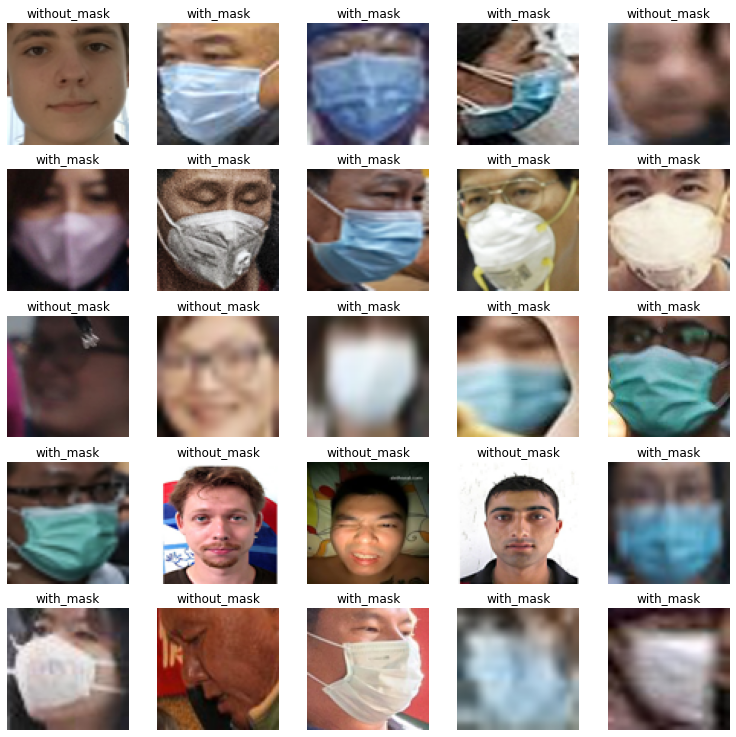

In [9]:
make_preview(images, labels)

## Splitting the data set into training and test data sets

In [10]:
# Divide dataset into classes
with_mask = np.where(labels == 'with_mask')
with_mask_data = images[with_mask]
with_mask_labels = labels[with_mask]

without_mask = np.where(labels == 'without_mask')
without_mask_data = images[without_mask]
without_mask_labels = labels[without_mask]

incorrect_mask = np.where(labels == 'incorrect')
incorrect_data = images[incorrect_mask]
incorrect_labels = labels[incorrect_mask]

In [11]:
print(len(with_mask_data), len(without_mask_data), len(incorrect_data))

6894 1984 520


In [12]:
def data_split(images, labels, test_size):
  if test_size < 1:
    test_size = int(len(images) * test_size)
  
  images, labels = shuffle(images, labels)
  X_test = images[:test_size]
  y_test = labels[:test_size]
  X_train = images[test_size:]
  y_train = labels[test_size:]

  return X_train, y_train, X_test, y_test

In [13]:
with_X_train, with_y_train, with_X_test, with_y_test = data_split(with_mask_data, with_mask_labels, 0.2)
print(len(with_X_train), len(with_X_test))

without_X_train, without_y_train, without_X_test, without_y_test = data_split(without_mask_data, without_mask_labels, 0.2)
print(len(without_X_train), len(without_X_test))

incorrect_X_train, incorrect_y_train, incorrect_X_test, incorrect_y_test = data_split(incorrect_data, incorrect_labels, 0.2)
print(len(incorrect_X_train), len(incorrect_X_test))

5516 1378
1588 396
416 104


In [15]:
def preprocess(image):
  return image / 127.5 - 1.0

In [16]:
X_train = np.concatenate([with_X_train, without_X_train, incorrect_X_train], axis=0)
y_train = np.concatenate([with_y_train, without_y_train, incorrect_y_train], axis=0)

X_test = np.concatenate([with_X_test, without_X_test, incorrect_X_test], axis=0)
y_test = np.concatenate([with_y_test, without_y_test, incorrect_y_test], axis=0)

vectorized_preprocess = np.vectorize(preprocess)
X_test_norm = vectorized_preprocess(X_test)

print(len(X_train), len(X_test))

7520 1878


In [17]:
del with_X_train
del with_y_train
del with_X_test
del with_y_test

del without_X_train
del without_y_train
del without_X_test
del without_y_test

del incorrect_X_train
del incorrect_y_train
del incorrect_X_test
del incorrect_y_test

## Encoding labels

In [18]:
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [19]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## Data Generator

In [20]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,
	  zoom_range=0.15,
	  width_shift_range=0.15,
	  height_shift_range=0.15,
	  shear_range=0.15,
	  horizontal_flip=True,
	  fill_mode="nearest",
    validation_split=0.2)

In [21]:
init_lr = 1e-4
epochs = 20
batch_size = 64

In [22]:
train_gen = gen.flow(
x=X_train,
y=y_train,
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True)

valid_gen = gen.flow(
x=X_train,
y=y_train,
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True)

In [23]:
step_size_train = train_gen.n//batch_size
step_size_valid = valid_gen.n//batch_size

## Functions

In [24]:
def accuracy(model, X_test, y_test, class_name=None):
  if class_name:
    labels = lb.inverse_transform(y_test)
    indices = np.where(labels == class_name)[0]
    X_test = X_test[indices]
    y_test = y_test[indices]
  test_preds = model.predict(X_test)
  m = tf.keras.metrics.CategoricalAccuracy()
  m.update_state(y_test, test_preds)
  return m.result().numpy()

In [25]:
def classification_report(model, X_test, y_test):
  classes = list(lb.classes_)
  classes = [None] + classes
  for c in classes:
    message = 'Total accuracy:' if c is None else c + ' accuracy:'
    print(message, accuracy(model, X_test, y_test, class_name=c))

In [26]:
def make_plot(H):
  keys = list(H.history.keys())
  for key in keys: 
    plt.plot(H.history[key])
    plt.ylabel('value')
    plt.xlabel('epoch')
  plt.legend(keys)
  plt.show()

In [27]:
def oversample(gen, ratio, batch_size):
  while True:
    n = gen.n
    images = []
    labels = []

    sizes = [int(r * batch_size) for r in ratio]
    sum_of_sizes = sum(sizes)
    res = batch_size - sum_of_sizes
    while res > 0:
      random_class = np.random.randint(0, len(ratio), size=1)[0]
      sizes[random_class] += 1
      res -= 1
    it = 0
    while any(s != 0 for s in sizes):
      data = gen.next()
      current_images = data[0]
      current_labels = np.argmax(data[1], axis=1)
      one_hot_labels = data[1]
      for i, s in enumerate(sizes):
        if s != 0:
          indices = np.where(current_labels == i)[0]
          if len(indices) >= s:
            images.extend(current_images[indices][:s])
            labels.extend(one_hot_labels[indices][:s])
            sizes[i] = 0
          else:
            images.extend(current_images[indices])
            labels.extend(one_hot_labels[indices])
            sizes[i] -= len(indices)
    
    images = np.array(images)
    labels = np.array(labels)
    images, labels = sklearn.utils.shuffle(images, labels)
    yield images, labels

In [46]:
over_train_gen = oversample(train_gen, [0.43, 0.29, 0.29], 64)
over_valid_gen = oversample(train_gen, [0.43, 0.29, 0.29], 64)

# MobileNetV2

In [47]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=input_shape))
baseModel.output

<KerasTensor: shape=(None, 3, 3, 1280) dtype=float32 (created by layer 'out_relu')>

In [48]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
#headModel = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(3, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [49]:
# compile our model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	over_train_gen,
	steps_per_epoch=step_size_train,
	validation_data=over_valid_gen,
	validation_steps=step_size_valid,
	epochs=epochs)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
94/94 [==============================] - 71s 740ms/step - loss: 1.1652 - acc: 0.6058 - val_loss: 0.4726 - val_acc: 0.8037
Epoch 2/20
94/94 [==============================] - 70s 753ms/step - loss: 0.5282 - acc: 0.7832 - val_loss: 0.3846 - val_acc: 0.8471
Epoch 3/20
94/94 [==============================] - 68s 736ms/step - loss: 0.4753 - acc: 0.8127 - val_loss: 0.3523 - val_acc: 0.8539
Epoch 4/20
94/94 [==============================] - 69s 737ms/step - loss: 0.3970 - acc: 0.8406 - val_loss: 0.3531 - val_acc: 0.8601
Epoch 5/20
94/94 [==============================] - 68s 736ms/step - loss: 0.3959 - acc: 0.8402 - val_loss: 0.2968 - val_acc: 0.8913
Epoch 6/20
94/94 [==============================] - 69s 743ms/step - loss: 0.3752 - acc: 0.8504 - val_loss: 0.2937 - val_acc: 0.9001
Epoch 7/20
94/94 [==============================] - 70s 748ms/step - loss: 0.3453 - acc: 0.8616 - val_loss: 0.2475 - val_acc: 0.9083
Epoch 8/20
94/94 [=

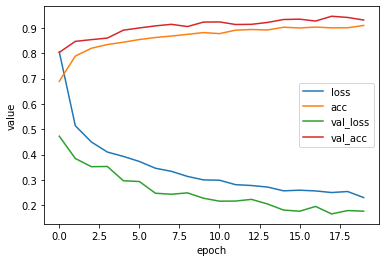

In [50]:
make_plot(H)

In [51]:
classification_report(model, X_test_norm, y_test)

Total accuracy: 0.9116081
incorrect accuracy: 0.88461536
with_mask accuracy: 0.9107402
without_mask accuracy: 0.92171717


In [52]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=input_shape))
baseModel.output

<KerasTensor: shape=(None, 3, 3, 1280) dtype=float32 (created by layer 'out_relu')>

In [53]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
#headModel = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(3, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [54]:
# compile our model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	over_train_gen,
	steps_per_epoch=step_size_train,
	validation_data=over_valid_gen,
	validation_steps=step_size_valid,
	epochs=epochs)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
94/94 [==============================] - 77s 790ms/step - loss: 1.1860 - acc: 0.5357 - val_loss: 0.6804 - val_acc: 0.7412
Epoch 2/20
94/94 [==============================] - 72s 774ms/step - loss: 0.5466 - acc: 0.7738 - val_loss: 0.6058 - val_acc: 0.7962
Epoch 3/20
94/94 [==============================] - 72s 778ms/step - loss: 0.3939 - acc: 0.8511 - val_loss: 0.4733 - val_acc: 0.8458
Epoch 4/20
94/94 [==============================] - 71s 758ms/step - loss: 0.2635 - acc: 0.9111 - val_loss: 0.4388 - val_acc: 0.8607
Epoch 5/20
94/94 [==============================] - 71s 768ms/step - loss: 0.2378 - acc: 0.9116 - val_loss: 0.3893 - val_acc: 0.8947
Epoch 6/20
94/94 [==============================] - 70s 749ms/step - loss: 0.1976 - acc: 0.9269 - val_loss: 0.3967 - val_acc: 0.9035
Epoch 7/20
94/94 [==============================] - 71s 757ms/step - loss: 0.1569 - acc: 0.9455 - val_loss: 0.3541 - val_acc: 0.9062
Epoch 8/20
94/94 [=

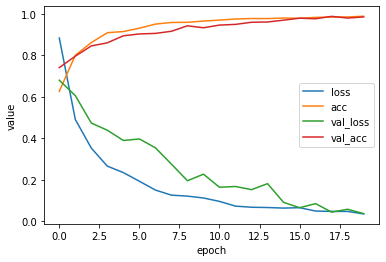

In [55]:
make_plot(H)

In [56]:
classification_report(model, X_test_norm, y_test)

Total accuracy: 0.96805114
incorrect accuracy: 0.9423077
with_mask accuracy: 0.9709724
without_mask accuracy: 0.96464646


In [57]:
model.save_weights('/content/drive/MyDrive/MaskDetection/mobilenetv2_all_layers.h5')